In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
from nltk.corpus import wordnet as wn
import json
import os
import requests
import random
import time
import re
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
import powerlaw
import numpy as np

[nltk_data] Downloading package wordnet to /home/abiget/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# !pip3 install powerlaw

Data Collection

LLM

In [ ]:
API_KEY = "SB7RLl13RiALifpPVLXfK3jAfXxiqAwO"
# svPU7ggOb1jfTScqf3F4f6CXjaPni13C

# Base URL for Mistral's OpenAI-compatible chat completions endpoint
API_URL = "https://api.mistral.ai/v1/chat/completions"

# Choose one of the available models (e.g., 'mistral-tiny', 'mistral-small', 'mistral-medium')
MODEL = "mistral-small"

# Headers for authentication and content type
HEADERS = {
    "Authorization": f"Bearer {API_KEY}",
    "Content-Type": "application/json"
}

In [ ]:
def chat_with_mistral(messages):
    """
    Sends a list of messages to the Mistral chat API and returns the assistant's response.

    Parameters:
        messages (list): A list of message dictionaries in the OpenAI chat format.
                         Example: [{"role": "user", "content": "Hello!"}]

    Returns:
        str: The assistant's reply as a string.
    """
    payload = {
        "model": MODEL,
        "messages": messages,
        "temperature": 0.7,     # Creativity level (0 = deterministic, 1 = more random)
        "top_p": 1.0,           # Nucleus sampling parameter
        "stream": False         # Disable streaming for simple usage
    }

    # Send a POST request to Mistral's API
    response = requests.post(API_URL, headers=HEADERS, data=json.dumps(payload))

    return response

In [ ]:
# a function to save the response to a file
def save_response_to_file(response, filename="response.txt"):
    with open(filename, "a") as file:
        file.write(response + "\n")
    # print(f"Response saved to {filename}")

In [ ]:
# Load the common adjectives from a JSON file
with open("data/common-adjectives.json", "r") as file:
    data = json.load(file)

In [ ]:
# Print the number of common adjectives as base words
print(len(data['CommonAdjectives']))

In [ ]:
def generate_data(prompt):
    # Initialize a conversation with a greeting
    examples = [
        "happy → joyful,content,pleased",
        "sad → unhappy,dejected,downcast",
        "fast → quick,swift,rapid",
    ]
    example = random.choice(examples)
    
    chat_history = [
        {"role": "user", 
         "content": (
             f"Generate only 3 to 10 synonyms for the word '{prompt}' as a single comma-separated string. "
             f"Do not add explanations, greetings, or anything else — only return the synonyms in this exact format: word1,word2,word3. "
             f"Example: {example}. No brackets, no quotes, no extra text, no whitespace between the first word and the second word except the comma. Just synonyms."
         )
        }
    ]

    try:
        # Send the message and receive the model's response
        return chat_with_mistral(chat_history)

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [ ]:

def fetch_with_retry(word, retries=3, delay=2):
    for i in range(retries):
        # Call the function to generate data
        response = generate_data(word)

        if response.status_code == 200:
            response_data = response.json()
            return response_data['choices'][0]['message']['content']
        elif response.status_code == 429:
            wait_time = delay * (2 ** i)
            print(f"Rate limited on '{word}'. Waiting {wait_time}s...")
            time.sleep(wait_time)
        else:
            print(f"Error fetching synonyms for '{word}': {response.status_code} - {response.text}")
            return None
    return None

In [ ]:
# List to store failed words when fetching synonyms
failed_words = []

In [ ]:
def generate_words_from_base_words(base_words):
    # Generate 3-10 synonyms for each word in the list
    # base_words = data['CommonAdjectives']
    # # base_words = extended_words
    
    for word in base_words:
        prompt = f"{word}"
        response = fetch_with_retry(prompt, retries=2, delay=2)
        
        if response is None:
            print(f"Failed to fetch synonyms for '{word}' after retries.")
            continue
        # break
        if re.match(r"^[a-zA-Z-]+(,[a-zA-Z-]+){1,9}$", response):
            for synonym in response.split(","):
                save_response_to_file(word + "," + synonym.strip(), "synonyms.csv")
            print(f"{word}: {synonym.strip()}")
        else:
            print(f"Invalid response format for '{word}': {response}")
            failed_words.append(word)
            continue

In [ ]:
# Generate synonyms for the common adjectives
generate_words_from_base_words(data['CommonAdjectives'])

In [ ]:
# Load the synonyms from the CSV file and remove duplicates
synonyms_df = pd.read_csv("synonyms.csv", header=None)
synonyms_df.columns = ["word", "synonym"]
synonyms_df = synonyms_df.drop_duplicates()

unique_synonyms = synonyms_df['synonym'].drop_duplicates().reset_index(drop=True)

In [ ]:
# Save the DataFrame to a CSV file
unique_synonyms.to_csv("base_synonyms_extended.csv", index=False)

In [ ]:
# number of base words
print(f"Number of base words: {len(data['CommonAdjectives'])}")
# number of unique synonyms
print(f"Number of extended base words: {len(unique_synonyms)}")

In [ ]:
# generate synonyms for the unique synonyms to expand our dataset
generate_words_from_base_words(unique_synonyms)

DATA Description:
1. LLM

We have used the most common 240 words from internet used them as a base word to generate 3-10 synonyms words using minstral llm and to extend our vocabulary we have used, 2373 unique words from the generated synonym words and agian generate 3-10 synonym words. 
- Number of base words: 240
- Number of extended base words: 2373

2. WordNet

We have used all the unique base words (i.e 598) from the above process and try to get at most 10 synonym words from the wordnet.

WordNet

In [ ]:
# example of using WordNet to find synonyms
synonyms = set()
for syn in wn.synsets("hide", ):
    for lemma in syn.lemmas():
        synonyms.add(lemma.name())
print(synonyms)

In [ ]:
def collect_synonyms_wordnet(word, pos=wn.ADJ, max_words=10):
    """
    Create an edge list for a given word using WordNet.
    """
    synonyms = set()
    # Get the synsets for the word
    synsets = wn.synsets(word, pos=pos)
    for synset in synsets:
        for lemma in synset.lemmas():
            if lemma.name() != word:
                synonyms.add(lemma.name().strip().replace('_', '-').lower())
                print(f"{word}: {lemma.name().strip()}")

                if len(synonyms) >= max_words:
                    # Save the synonyms to a CSV file
                    for synonym in synonyms:
                        save_response_to_file(word + "," + synonym.strip(), "synonyms_wordnet.csv")
                        print(f"{word}: {synonym.strip()}")
                    return

    if synonyms is not None:
        # If we reach here, the num of synonyms is less than max_words so we save them
        for synonym in synonyms:
            save_response_to_file(word + "," + synonym.strip(), "synonyms_wordnet.csv")
            print(f"{word}: {synonym.strip()}") 

In [ ]:
# List of words to process
words_for_wordnet = pd.read_csv("synonyms.csv", header=None, names=["word", "synonym"])['word'].drop_duplicates().reset_index(drop=True)

# Generate synonyms for the unique words using WordNet
words_for_wordnet.apply(lambda x: collect_synonyms_wordnet(x, pos=wn.ADJ))

In [ ]:
print("Number of unique words to be use as base words for WordNet:", len(words_for_wordnet))

Synonym Net

In [ ]:
class CommonSynonymNetworkAnalyzer:
    """Analyze and compare common nodes between LLM and WordNet synonym networks"""
    
    def __init__(self, llm_file_path, wordnet_file_path):
        """Initialize with paths to data files"""
        self.llm_file_path = llm_file_path
        self.wordnet_file_path = wordnet_file_path
        
        # Load the full networks
        self.G_llm = self._load_network(llm_file_path)
        self.G_wordnet = self._load_network(wordnet_file_path)
        
        # Extract common subgraphs
        self._extract_common_subgraphs()
        
    def _load_network(self, file_path):
        """Load a network from a CSV file of word pairs"""
        G = nx.Graph()
        
        with open(file_path, 'r') as file:
            for line in file:
                line = line.strip()
                if not line or ',' not in line:
                    continue
                word1, word2 = line.split(',')
                G.add_edge(word1, word2)
        
        return G
    
    def _extract_common_subgraphs(self):
        """Extract and process common node subgraphs"""
        # Find common nodes between networks
        common_nodes = set(self.G_llm.nodes()).intersection(self.G_wordnet.nodes())
        print(f"Number of common nodes: {len(common_nodes)}")
        
        # Create initial common subgraphs
        self.G_llm_common = self.G_llm.subgraph(common_nodes).copy()
        self.G_wordnet_common = self.G_wordnet.subgraph(common_nodes).copy()
        
        # Identify disconnected nodes
        disconnected_llm = [n for n in self.G_llm_common.nodes if self.G_llm_common.degree(n) == 0]
        disconnected_wordnet = [n for n in self.G_wordnet_common.nodes if self.G_wordnet_common.degree(n) == 0]
        
        print(f"Disconnected nodes in LLM: {len(disconnected_llm)}")
        print(f"Disconnected nodes in WordNet: {len(disconnected_wordnet)}")
        
        # Create connected subgraphs by removing disconnected nodes
        connected_nodes_llm = [n for n in self.G_llm_common.nodes if n not in disconnected_llm]
        connected_nodes_wordnet = [n for n in self.G_wordnet_common.nodes if n not in disconnected_wordnet]
        
        self.G_llm_common_connected = self.G_llm_common.subgraph(connected_nodes_llm).copy()
        self.G_wordnet_common_connected = self.G_wordnet_common.subgraph(connected_nodes_wordnet).copy()

    def benchmark_random_graphs(self, G, num_simulations=100, swaps_per_edge=5):
        """Benchmark random graphs using double edge swap method"""
        nswap = swaps_per_edge * G.number_of_edges()
        num_tries = 5 * nswap

        L_list = []
        C_list = []

        for _ in range(num_simulations):
            G_rand = nx.double_edge_swap(G.copy(), nswap=nswap, max_tries=num_tries)

            C = nx.average_clustering(G_rand)

            largest_cc = max(nx.connected_components(G_rand), key=len)
            G_sub = G_rand.subgraph(largest_cc).copy()
            L = nx.average_shortest_path_length(G_sub)

            L_list.append(L)
            C_list.append(C)

        Lrandom = np.mean(L_list)
        Crandom = np.mean(C_list)

        return Crandom, Lrandom
    

    def _plot_degree_distributions(self, fit_wnet, fit_llm, names):
        """Plot degree distributions of common node networks"""
        # Plot the degree distribution
        fig, axes = plt.subplots(1, 2, figsize=(12, 8))
        
        fig.supxlabel("Degree")
        fig.supylabel("Probability")
        fig.suptitle("Degree Distribution of WordNet and LLM Networks", fontsize=14)

        fit_wnet.plot_pdf(ax=axes[0], color='b', label='Degree Distribution', marker='o', markersize=6)
        fit_wnet.power_law.plot_pdf(ax=axes[0], color='r', label='Power law fit', marker='o', markersize=6)
        fit_wnet.exponential.plot_pdf(ax=axes[0], color='g', label="Exponential fit", marker='o', markersize=6)
        # axes[0].set_title(f"Degree Distribution of {names[0]} Network")
        # axes[0].set_xlabel("Degree")
        # axes[0].set_ylabel("Probability")
        axes[0].legend()
        axes[0].grid(True)

        fit_llm.plot_pdf(ax=axes[1], color='b', label='Degree Distribution', marker='o', markersize=6)
        fit_llm.power_law.plot_pdf(ax=axes[1], color='r', label='Power law fit', marker='o', markersize=6)
        fit_llm.exponential.plot_pdf(ax=axes[1], color='g', label="Exponential fit", marker='o', markersize=6)
        # axes[1].set_title(f"Degree Distribution of {names[1]} Network")
        # axes[1].set_xlabel("Degree")
        # axes[1].set_ylabel("")
        axes[1].legend()
        axes[1].grid(True)

        plt.tight_layout()
        plt.savefig(f'figures/{names[0]}_{names[1]}_degree_distribution.eps', dpi=300)
        plt.show()
    
    def check_for_power_law(self, G_wnet, G_llm, names):
        """Check if the degree distribution follows a power law"""

        degree_sequence_wnet = sorted([d for n, d in G_wnet.degree()], reverse=True)
        degree_sequence_llm = sorted([d for n, d in G_llm.degree()], reverse=True)

        # Fit distributions
        fit_wnet = powerlaw.Fit(degree_sequence_wnet, discrete=True)
        fit_llm = powerlaw.Fit(degree_sequence_llm, discrete=True)

         # compare the data distribution fit power law vs exponential for Wordnet
        R_wnet, p_wnet = fit_wnet.distribution_compare('power_law', 'exponential')
        print(f"{names[0]}--------------------------")
        print(f"Power-law vs Exponential: R = {R_wnet}, p = {p_wnet} => {'sigificant with 5% level' if p_wnet < 0.05 else 'not significant'}")

        # compare the data distribution fit power law vs exponential for LLM
        R_llm, p_llm = fit_llm.distribution_compare('power_law', 'exponential')
        print(f"{names[1]}--------------------------")
        print(f"Power-law vs Exponential: R = {R_llm}, p = {p_llm} => {'significatn with 5% level' if p_llm < 0.05 else 'not significant'}")

        # plot degree distributions along with the fitted distributions
        self._plot_degree_distributions(fit_wnet, fit_llm, names)

    
    def compare_networks(self):
        """Compare basic properties of common node networks"""
        metrics = {}
        
        for name, G in [("WordNet", self.G_wordnet_common_connected), 
                        ("LLM", self.G_llm_common_connected)]:
            num_nodes = G.number_of_nodes()
            num_edges = G.number_of_edges()
            density = nx.density(G)
            avg_clustering = nx.average_clustering(G)
            # calculate closeness centrality
            avg_closeness_centrality = sum(nx.closeness_centrality(G).values())/num_nodes
            # calculate betweenness centrality
            avg_betweenness_centrality = sum(nx.betweenness_centrality(G).values())/num_nodes
            # calculate degree centrality
            avg_degree_centrality = sum(nx.degree_centrality(G).values())/num_nodes

            components = list(nx.connected_components(G))
            largest_cc = max(components, key=len)
            G_lcc = G.subgraph(largest_cc).copy()

            # the number of nodes in the largest connected component
            num_nodes_lcc = G_lcc.number_of_nodes()

            # calculate average shortest path length
            avg_shortest_path_length = nx.average_shortest_path_length(G_lcc)

            # Calculate average clustering coefficient for the largest connected component of random graphs
            clustering_coeff_random, shortest_path_length_random = self.benchmark_random_graphs(G)
            
            metrics[name] = {
                "nodes": num_nodes,
                "edges": num_edges,
                "density": density,
                "closeness_centrality": avg_closeness_centrality,
                "betweenness_centrality": avg_betweenness_centrality,
                "degree_centrality": avg_degree_centrality,
                "number_of_components": len(components),
                "nodes_in_largest_cc": num_nodes_lcc,
                "avg_clustering": avg_clustering,
                "avg_shortest_path_length_lcc": avg_shortest_path_length,
                "avg_clustering_random": clustering_coeff_random,
                "avg_shortest_path_length_random_lcc": shortest_path_length_random
            }

        # Check for power law distribution
        self.check_for_power_law(self.G_wordnet_common_connected, self.G_llm_common_connected, ["WordNet", "LLM"])
        
        return pd.DataFrame(metrics)
    
    def get_top_nodes_by_degree(self, k=10):
        """Get top nodes by degree for both common networks"""
        results = {}
        
        for name, G in [("WordNet", self.G_wordnet_common_connected), 
                        ("LLM", self.G_llm_common_connected)]:
            degree_dict = dict(G.degree())
            sorted_nodes = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:k]
            results[name] = sorted_nodes
            
            print(f"Top {k} nodes by degree in {name} Common Network:")
            for node, degree in sorted_nodes:
                print(f"  {node}: {degree}")
            print("="*40)
        
        return results
    
    def get_top_clustering_nodes(self, k=10):
        """Get top nodes by clustering coefficient for both common networks"""
        results = {}
        
        for name, G in [("WordNet", self.G_wordnet_common_connected), 
                        ("LLM", self.G_llm_common_connected)]:
            clustering_dict = nx.clustering(G)
            sorted_nodes = sorted(clustering_dict.items(), key=lambda x: x[1], reverse=True)[:k]
            results[name] = sorted_nodes
            
            print(f"Top {k} nodes by clustering in {name} Common Network:")
            for node, coeff in sorted_nodes:
                print(f"  {node}: {coeff:.4f}")
            print("="*40)
        
        return results
    
    def visualize_neighborhood(self, word, radius=2, layout='spring'):
        """Visualize neighborhood of a word in both common networks"""
        fig, axes = plt.subplots(1, 2, figsize=(12, 8))
        for (label, G), axis in zip([("LLM", self.G_llm_common_connected), 
                        ("WordNet", self.G_wordnet_common_connected)], axes):
            if word not in G:
                print(f'The word "{word}" is not in the {label} graph.')
                continue
            
            self._plot_neighborhood(G, word, radius, label, layout, axis)
        plt.suptitle(f"Neighborhood of '{word}' (radius={radius}) LLM vs WordNet", fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'figures/{word}_neighborhood_comparison.eps', dpi=300)
        plt.show()


    def _plot_neighborhood(self, G, word, radius=2, label=None, layout='spring', axis=None):
        """Helper method to plot neighborhood of a word"""
        # Create ego graph
        neighborhood = nx.ego_graph(G, word, radius=radius)

        # Use Seaborn's whitegrid style for a cleaner aesthetic
        sns.set_style("whitegrid")

        # Choose layout
        if layout == 'spring':
            pos = nx.spring_layout(neighborhood, seed=42)
        elif layout == 'circular':
            pos = nx.circular_layout(neighborhood)
        elif layout == 'kamada_kawai':
            pos = nx.kamada_kawai_layout(neighborhood)
        elif layout == 'spectral':
            pos = nx.spectral_layout(neighborhood)
        else:
            pos = nx.spring_layout(neighborhood, seed=42)

        # Node and edge drawing
        nx.draw_networkx_edges(
            neighborhood, pos, connectionstyle='arc3, rad=0.2',
            edge_color='gray', alpha=0.5, arrows=True, ax=axis
        )

        nx.draw_networkx_nodes(
            neighborhood, pos, node_color='#69b3a2',
            node_size=0, edgecolors='black', linewidths=0.6, ax=axis
        )

        nx.draw_networkx_labels(
            neighborhood, pos, font_size=10,
            font_weight='bold', font_color='black',
            ax=axis
        )

        axis.axis('off')
        # axis.set_title(
        #     f"Synonyms Network of '{word}' (radius={radius})" + (f" - {label}" if label else ""),
        #     fontsize=16, fontweight='bold'
        # )

Number of common nodes: 939
Disconnected nodes in LLM: 23
Disconnected nodes in WordNet: 66
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
WordNet--------------------------
Power-law vs Exponential: R = -4.351632854756233, p = 0.014428683690620612 => sigificant with 5% level
LLM--------------------------
Power-law vs Exponential: R = -1.047376307799723, p = 0.4776318501658984 => not significant


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


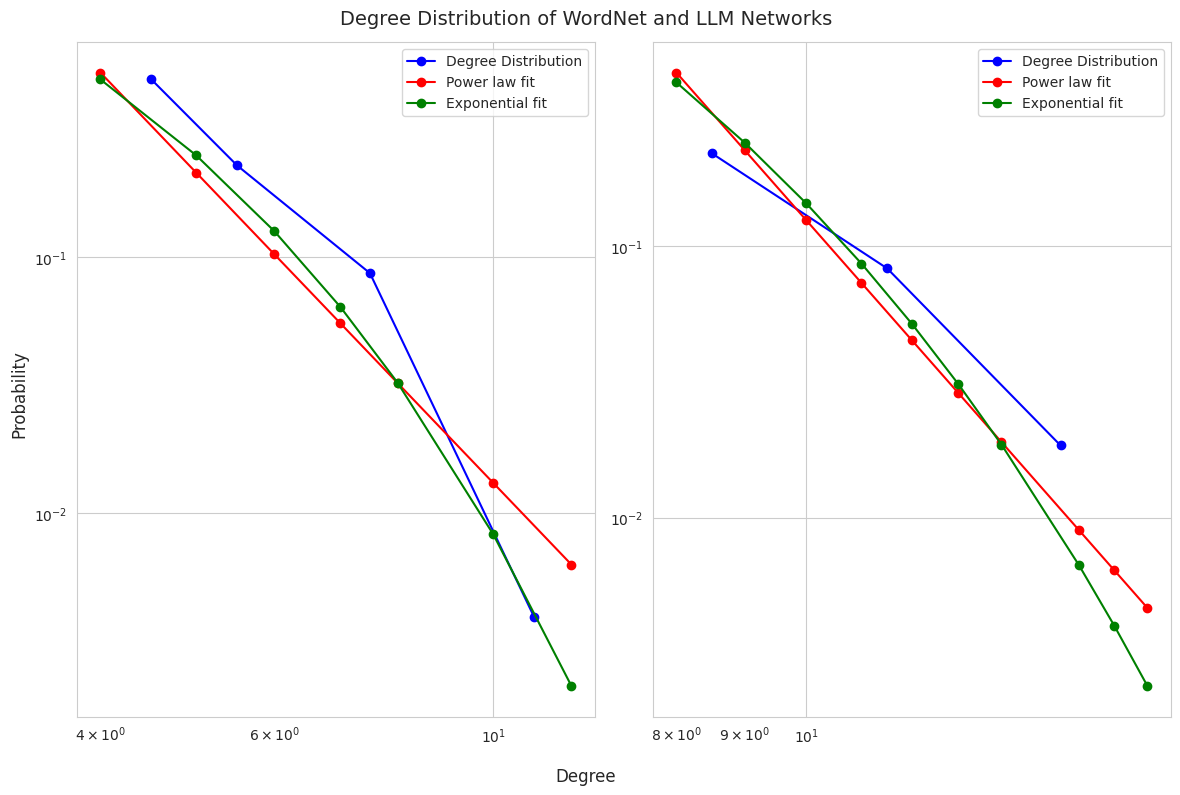

Top 10 nodes by degree in WordNet Common Network:
  good: 12
  dim: 10
  fresh: 8
  free: 8
  strong: 8
  sharp: 8
  new: 7
  keen: 7
  slight: 7
  small: 7
Top 10 nodes by degree in LLM Common Network:
  clear: 18
  paramount: 17
  notable: 16
  sharp: 16
  preeminent: 14
  modest: 14
  significant: 13
  insignificant: 13
  dirty: 13
  small: 13


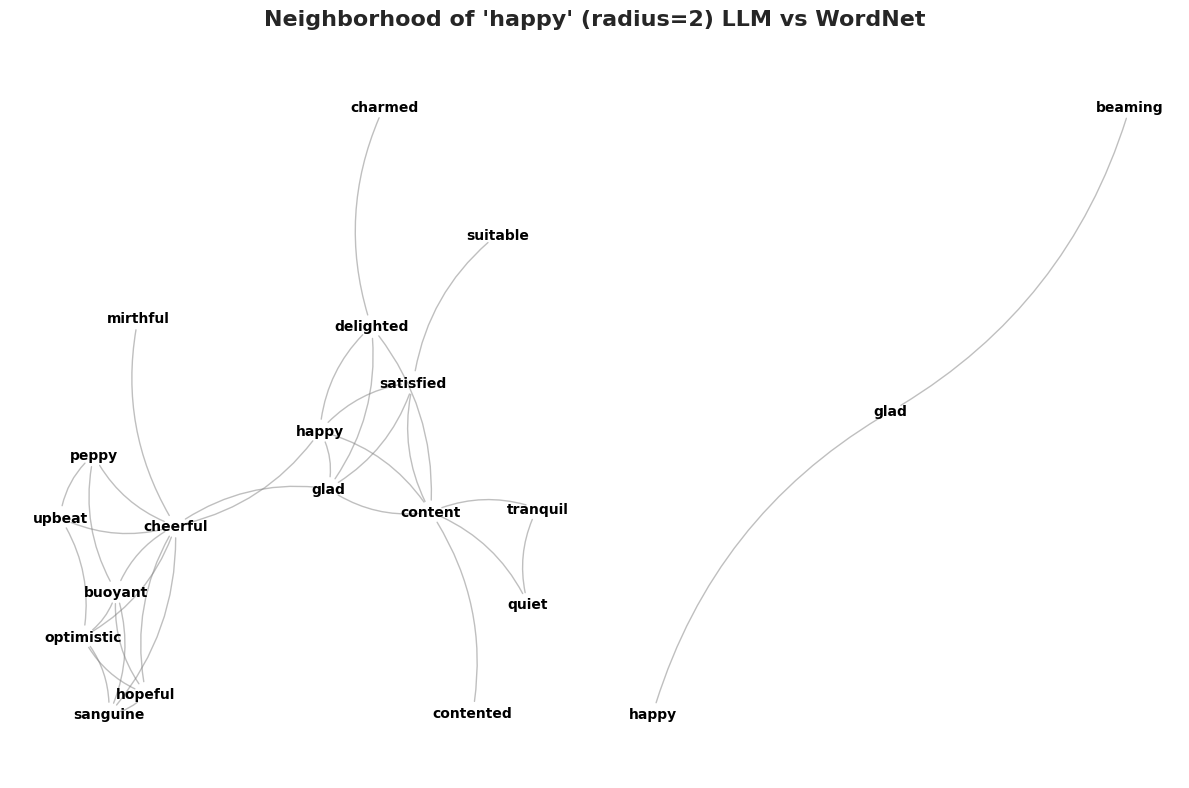

In [5]:
analyzer = CommonSynonymNetworkAnalyzer(
    llm_file_path='data/synonyms.csv',
    wordnet_file_path='data/synonyms_wordnet.csv'
)

# Analyze the common networks
analyzer.compare_networks()
analyzer.get_top_nodes_by_degree()

# Visualize specific words
for word in ['happy', 'glum']:
    analyzer.visualize_neighborhood(word, layout='spring')
    break